In [172]:
from pathos.multiprocessing import ProcessPool
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
import cython

In [173]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [174]:
"""
rho = 0.85
h = 0.016
m = 48
T = 1
M = 6 # cube root of number of unit cells in the L^3 volume, gives N=864 particles
L = (4*6**3)/rho
sigma = 3.405 #Angstrom
epsilon = 119.8 #K
# Todo: Scale time
"""

'\nrho = 0.85\nh = 0.016\nm = 48\nT = 1\nM = 6 # cube root of number of unit cells in the L^3 volume, gives N=864 particles\nL = (4*6**3)/rho\nsigma = 3.405 #Angstrom\nepsilon = 119.8 #K\n# Todo: Scale time\n'

In [175]:
%%cython
import numpy as np
from itertools import product
from tqdm import tqdm

cdef float rho = 0.85
cdef float h = 0.016
cdef int m = 48 # Be aware that m is also defined later outside of the cython
cdef float T = 2.0
cdef int M = 4   # cube root of number of unit cells in the L^3 volume, gives N=864 particles
cdef float L = np.cbrt((4*M**3)/rho)

list_pbc = list(product([0, 1, -1], repeat=3))
list_pbc = L*np.array(list_pbc)

def f_optimized(double[:] r_i, double[:] r_j):
    cdef int d
    cdef double[:] vec_L_min
    cdef double[:] r_ij_candidates = np.zeros(27)
    
    for i, vec_L in enumerate(list_pbc):
        for d in range(3):
            r_ij_candidates[i] += (r_i[d] - r_j[d] + L*vec_L[d])**2
        
    cdef int index_L_min = np.argmin(r_ij_candidates)
    vec_L_min = L * list_pbc[index_L_min]
    cdef double r_ij = (r_ij_candidates[index_L_min])
    
    cdef double f_x = m * (r_i[0] - r_j[0] + vec_L_min[0]) * (r_ij**(-14) + 0.5 * r_ij**(-8))
    cdef double f_y = m * (r_i[1] - r_j[1] + vec_L_min[1]) * (r_ij**(-14) + 0.5 * r_ij**(-8))
    cdef double f_z = m * (r_i[2] - r_j[2] + vec_L_min[2]) * (r_ij**(-14) + 0.5 * r_ij**(-8))
    
    return np.array([f_x, f_y, f_z])

def f(r_i, r_j):
    #Todo: Cut potential for r_ij > sigma
    
    r_ij_candidates = [np.sum([(r_i[d]-r_j[d]+vec_L[d])**2 for d in range(3)]) for vec_L in list_pbc]
    index_L_min = np.argmin([r_ij_candidates])#list_pbc[index_min]
    vec_L_min = list_pbc[index_L_min]
    r_ij = np.sqrt(r_ij_candidates[index_L_min])
    f_x = m*(r_i[0]-r_j[0]+vec_L_min[0])*(r_ij**(-14)+0.5*r_ij**(-8))
    f_y = m*(r_i[1]-r_j[1]+vec_L_min[1])*(r_ij**(-14)+0.5*r_ij**(-8))
    f_z = m*(r_i[2]-r_j[2]+vec_L_min[2])*(r_ij**(-14)+0.5*r_ij**(-8))
    return np.array([f_x, f_y, f_z])

def arange_without(i):
    original_array = np.arange(4*M**3)
    result_array = original_array[original_array != i]
    return result_array

def F(r):
    return np.array([np.sum(np.array([f_optimized(r[i], r[k]) for k in arange_without(i)]), axis=0) for i in range(r.shape[0])])
    #return [f(r[i], r[k]) for k in arange_without(i)] pool.map()
    #pool = ProcessPool(nodes=4)
    #results = pool.map(f_subprocess, (r for i in range(r.shape[0])), range(r.shape[0]))
    #return np.array(results)

def verlet_step(r, v):
    v_tilde = v + h/(2*m)*F(r)
    r_next = r + h*v_tilde
    f_next = F(r_next)
    v_next = v_tilde + (h/(2*m))*f_next
    return r_next, v_next

def verlet_algorithm(r_0, v_0, num_steps):
    list_r = [r_0]
    list_v = [v_0]
    for t in tqdm(range(num_steps)):
        r_new, v_new = verlet_step(list_r[-1], list_v[-1])
        list_r.append(r_new)
        list_v.append(v_new)
    return np.array(list_r), np.array(list_v)

def build_fcc():
    """
    :param M: integer. cube root of Number of unit cells
    :return: fcc grid for the L*L cube (np.array of shape (n_points, 3))
    """
    range_values_sc = np.linspace(-L/2, L/2, M+1)
    length_edge = np.abs(range_values_sc[0]-range_values_sc[1]) #L/(rho-1)
    sc_grid = np.array(list(product(range_values_sc, repeat=3)))
    sc_grid = sc_grid[sc_grid[:, 0] != -L/2]
    sc_grid = sc_grid[sc_grid[:, 1] != -L/2]
    sc_grid = sc_grid[sc_grid[:, 2] != -L/2]
    missing_points = []
    for point in sc_grid:
        p1 = [point[0]+0.5*length_edge, point[1], point[2]+0.5*length_edge]
        p2 = [point[0]+0.5*length_edge, point[1]+0.5*length_edge, point[2]]
        p3 = [point[0], point[1]+0.5*length_edge, point[2]+0.5*length_edge]
        missing_points.append(p1)
        missing_points.append(p2)
        missing_points.append(p3)
    missing_points = np.array(missing_points)
    x = sc_grid[:,0]
    y = sc_grid[:,1]
    z = sc_grid[:,2]
    x_m = missing_points[:,0]
    y_m = missing_points[:,1]
    z_m = missing_points[:,2]
    fcc_grid = np.concatenate([sc_grid, missing_points])

    return fcc_grid

def Temperature(v):
    return 16*np.mean([(v_i[0]**2)+(v_i[1]**2)+(v_i[2]**2) for v_i in v])

performance hint: C:\Users\corin\.ipython\cython\_cython_magic_23f261e7623328adf726778210492473f292b5b3.pyx:22:28: Index should be typed for more efficient access


Content of stdout:
_cython_magic_23f261e7623328adf726778210492473f292b5b3.c
C:\Users\corin\.ipython\cython\_cython_magic_23f261e7623328adf726778210492473f292b5b3.c(24063): warning C4305: "=": Verkrzung von "double" in "float"
C:\Users\corin\.ipython\cython\_cython_magic_23f261e7623328adf726778210492473f292b5b3.c(24072): warning C4305: "=": Verkrzung von "double" in "float"
   Bibliothek "C:\Users\corin\.ipython\cython\Users\corin\.ipython\cython\_cython_magic_23f261e7623328adf726778210492473f292b5b3.cp311-win_amd64.lib" und Objekt "C:\Users\corin\.ipython\cython\Users\corin\.ipython\cython\_cython_magic_23f261e7623328adf726778210492473f292b5b3.cp311-win_amd64.exp" werden erstellt.
Code wird generiert.
Codegenerierung ist abgeschlossen.

In [176]:
T = 2.0
sigma = 3.405 #Angstrom
epsilon = 119.8 #K
m = 48 # Be careful, m is also defined in the cython

r_0 = build_fcc()
N_0 = r_0.shape[0]
#np.random.uniform(-L/2, L/2, (N_0, 3)) #randomly between 0 and L with gaussian distribution, mean 0, std sqrt(kT^*/m^*), m^* = 48, k = 1, are the velocities normally distributed in every seperate direction?
v_0 = np.random.normal(0,np.sqrt(T/epsilon*m), (N_0, 3))
tp = np.sqrt(48*epsilon/(m*sigma**2)) #*t

"""
r_0: Initial positions of the system
    r_0[i]: 1D-array with 3 values, the coordinates of the i'th particle
v_0: Initial velocities of the system particles
    v_0[i]: 1D-array with 3 values, the velocity values of the i'th particle
"""

"\nr_0: Initial positions of the system\n    r_0[i]: 1D-array with 3 values, the coordinates of the i'th particle\nv_0: Initial velocities of the system particles\n    v_0[i]: 1D-array with 3 values, the velocity values of the i'th particle\n"

In [177]:
print(N_0)

256


Text(0.5, 0.92, 'Initial state of the Argon ')

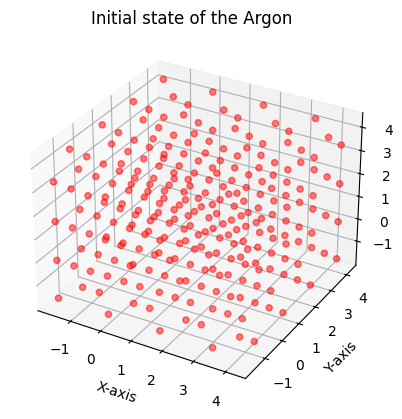

In [178]:
#Seeing how the initial state looks like
#ax = plt.figure().add_subplot(projection='3d')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Extract x, y, and z coordinates
x = r_0[:,0].flatten()
y = r_0[:,1].flatten()
z = r_0[:,2].flatten()

# Plot the points
ax.scatter(x, y, z, c='r', marker='o', alpha=0.5)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set the title
ax.set_title('Initial state of the Argon ')

# Show the plot
#plt.show()

In [179]:
t_max = 1000

r_total, v_total = verlet_algorithm(r_0, v_0, t_max)

100%|██████████| 1000/1000 [57:39<00:00,  3.46s/it]


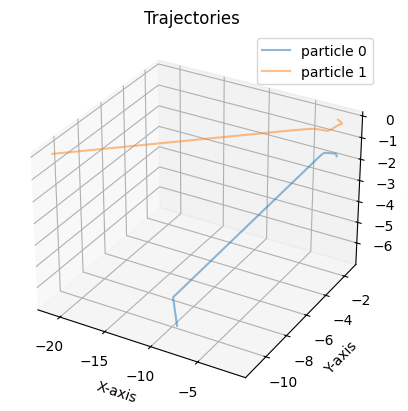

In [180]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot(r_total[:,0,0], r_total[:,0,1], r_total[:,0,2], alpha=0.5, markersize= 10, label= "particle 0")
ax.plot(r_total[:,1,0], r_total[:,1,1], r_total[:,1,2], alpha=0.5, markersize=10, label= "particle 1")

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Trajectories ')
plt.legend()

Text(0, 0.5, '$T^*$')

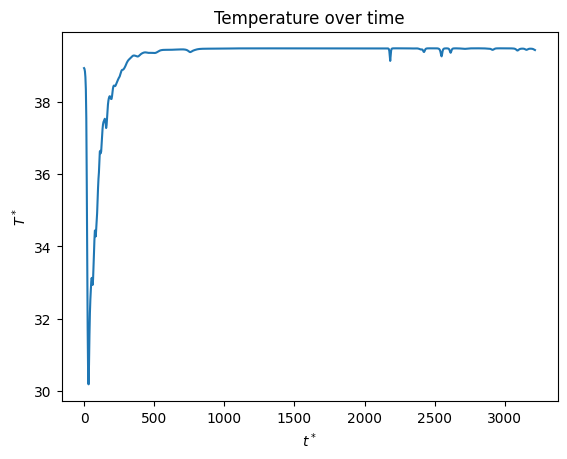

In [181]:
T_total = [Temperature(v_t) for v_t in v_total]
plt.plot(np.arange(t_max+1)*tp, T_total)
plt.title("Temperature over time")
plt.xlabel("$t^*$")
plt.ylabel("$T^*$")

In [182]:
T_total

[38.92883981058624,
 38.90686895456858,
 38.835494900304816,
 38.68200476969534,
 38.34837949011497,
 37.54824005963201,
 35.80214507518352,
 33.55525266641739,
 31.745513602938566,
 30.514029815786802,
 30.18408978821645,
 30.739629151525875,
 31.551524584875963,
 32.1579950716518,
 32.53063088082075,
 32.78594994269926,
 33.032033588822685,
 33.127173769607126,
 33.01924776746218,
 32.93355037504449,
 33.08923197685729,
 33.42263981472806,
 33.800803729390665,
 34.1779518797288,
 34.43479939235503,
 34.44276761038108,
 34.275551774549704,
 34.488869262452376,
 34.71266998650903,
 34.918963162087636,
 35.26779875116966,
 35.606243759411385,
 35.868710743458124,
 36.0460838351612,
 36.3444555384426,
 36.622945599488666,
 36.641526298021965,
 36.5738332587034,
 36.62609943883943,
 36.832686015464844,
 37.059802323312496,
 37.243995327953215,
 37.368929841787406,
 37.4345011317009,
 37.468012650197245,
 37.50038389996439,
 37.52785753357663,
 37.50030388949607,
 37.37692296499519,
 37.27

In [187]:
flattened_array_r = r_total.reshape(-1, r_total.shape[-1])
flattened_array_v = v_total.reshape(-1, v_total.shape[-1])

# Save the flattened array to a CSV file

np.savetxt("r_total.txt", flattened_array_r, delimiter=",")
np.savetxt("v_total.txt", flattened_array_v, delimiter=",")

In [183]:
plt.plot(np.arange(t_max+1)*tp, [F(r_total[t])[0,0] for t in range(t_max+1)])
plt.title("Force that acts on particle 0 in x-direction over time")

KeyboardInterrupt: 